### Initial Setup and Data Loading

We begin by importing the core libraries that drive the pipeline. Each plays a distinct role in the workflow. Pandas will serve as the main workhorse for cleaning, transforming, and feature engineering. Numpy is for numerical support for preprocessing and statistical checks.Matplotlib & Seaborn is for visualization libraries used for exploratory validation of assumptions. os is for handling file paths and export management.

This reflects a BI‑oriented pipeline (lightweight, dashboard‑ready) rather than a heavyweight ML research environment.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from catboost import Pool

The raw transactional dataset is ingested from CSV. This dataset simulates e‑commerce operations with fields such as order IDs, customer demographics, product categories, and financial metrics.

In [2]:
df = pd.read_csv(r"/Users/neilkeannedelavega/Downloads/E-commerce-Data-Insights-Dashboard/data/ecommerce_sales_raw.csv")

This ingestion step is the foundation for all downstream BI dashboards. The raw fields here later drive data visualization charts. 

A quick preview validates that the file path is correct, the delimiter is recognized, and the structure matches expectations.

Checks performed:
 - Columns align with transactional expectations (order_id, customer_id, price, discount, order_date, etc.).
 
 - No immediate structural issues appear.

- Confirms the dataset is suitable for BI analysis.

In [3]:
df.head()

,order_id,customer_id,product_id,category,price,discount,quantity,payment_method,order_date,delivery_time_days,region,returned,total_amount,shipping_cost,profit_margin,customer_age,customer_gender
0,O100000,C17270,P234890,Home,164.08,0.15,1,Credit Card,2023-12-23,4,West,No,139.47,7.88,31.17,60,Female
1,O100001,C17603,P228204,Grocery,24.73,0.00,1,Credit Card,2025-04-03,6,South,No,24.73,4.60,-2.62,37,Male
2,O100002,C10860,P213892,Electronics,175.58,0.05,1,Credit Card,2024-10-08,4,North,No,166.80,6.58,13.44,34,Male
3,O100003,C15390,P208689,Electronics,63.67,0.00,1,UPI,2024-09-14,6,South,No,63.67,5.50,2.14,21,Female
4,O100004,C15226,P228063,Home,16.33,0.15,1,COD,2024-12-21,6,East,No,13.88,2.74,1.15,39,Male


In [4]:
df.shape

(34500, 17)

The dataset contains 34,500 rows and 17 columns, a manageable size suitable for BI dashboards and light predictive work.

In [5]:
df.columns

Index(['order_id', 'customer_id', 'product_id', 'category', 'price',
       'discount', 'quantity', 'payment_method', 'order_date',
       'delivery_time_days', 'region', 'returned', 'total_amount',
       'shipping_cost', 'profit_margin', 'customer_age', 'customer_gender'],
      dtype='object')

The field names are clean and already analysis-ready, removing the need for renaming or manual parsing. This is unusual for raw retail data, but expected in synthetic Kaggle datasets.

In [6]:
df.dtypes

order_id               object
customer_id            object
product_id             object
category               object
price                 float64
discount              float64
quantity                int64
payment_method         object
order_date             object
delivery_time_days      int64
region                 object
returned               object
total_amount          float64
shipping_cost         float64
profit_margin         float64
customer_age            int64
customer_gender        object
dtype: object

Numeric fields (price, discount, quantity, etc.) are correctly typed.

Issue: order_date is still an object.

- Needs explicit conversion to datetime for temporal features (recency, tenure, seasonality).

- Defensive conversion with errors='coerce' will be applied later.

This initial setup ensures the dataset is correctly ingested and structurally valid. It sets the stage for:

- Data quality checks (feeding into Actual Return Rate by Category chart).

- Feature engineering (feeding into Delivery Speed Breakdown chart).

- Predictive modeling (feeding into Top Drivers of Product Returns chart)

### Data Quality Checks (Missing, Duplicates, Outliers)

This section validates the quality of the dataset before performing deeper preprocessing. Since the file originates from a Kaggle project that simulates E-commerce operations, it is expected to be cleaner than real transactional data, although it still mirrors the structure and statistical behavior of real-world sales systems.

In [7]:
df.isnull().sum()

order_id              0
customer_id           0
product_id            0
category              0
price                 0
discount              0
quantity              0
payment_method        0
order_date            0
delivery_time_days    0
region                0
returned              0
total_amount          0
shipping_cost         0
profit_margin         0
customer_age          0
customer_gender       0
dtype: int64

Findings:

- No missing values detected across all 17 fields.

- This is expected for synthetic Kaggle data, but it simplifies the pipeline.

- No imputation is required for BI dashboards or ML baselines.

Business context:

- Clean inputs ensure that metrics like Actual Return Rate by Category are not distorted by null handling.

#### Duplicate Records

In [8]:
df.duplicated().sum() 

0

We check for duplicate rows to confirm transactional uniqueness.

Findings:

-  No duplicates detected.

- In real systems, duplicates often arise from ingestion errors or repeated API calls.

- Here, uniqueness is guaranteed, but the check is still essential to prevent inflated aggregations.

Business context:

- Guarantees that Sales by Category and time‑series breakdowns reflect true transactions.

#### Date Conversion

The order_date column arrives as an object type.

In [9]:
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')

Rationale:

- Conversion to datetime enables temporal features (month, year, recency, tenure).

- errors='coerce' ensures robustness — malformed entries become NaT instead of breaking the pipeline.

Business context:

- Enables dashboards to analyze seasonality and delivery speed trends.

#### Descriptive Statistics

We profile numeric fields to confirm plausible ranges.

In [10]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols].describe()

,price,discount,quantity,delivery_time_days,total_amount,shipping_cost,profit_margin,customer_age
count,34500.000000,34500.000000,34500.000000,34500.000000,34500.000000,34500.000000,34500.000000,34500.000000
mean,119.391632,0.049291,1.490725,4.814203,170.008494,6.152120,28.116505,43.474377
std,195.620477,0.069894,0.932270,1.242141,357.503014,2.389539,53.352947,14.980682
min,1.010000,0.000000,1.000000,3.000000,0.820000,0.000000,-6.200000,18.000000
25%,16.690000,0.000000,1.000000,4.000000,19.710000,4.420000,1.500000,31.000000
50%,45.660000,0.000000,1.000000,5.000000,56.820000,6.090000,10.550000,43.000000
75%,130.950000,0.100000,2.000000,6.000000,168.530000,7.830000,33.132500,56.000000
max,2930.470000,0.300000,5.000000,13.000000,12931.800000,15.650000,1536.170000,69.000000


Observations:

- Price: ranges from 1 to ~2,900 which is plausible for mixed categories.

- Delivery time: 3-13 days, consistent with typical 3–7 day windows plus slower deliveries.

- Profit margin: includes negatives, reflecting discounts or loss‑leader strategies.

- Customer age: 18–69, realistic bracket for online shoppers.

Business context:

- Confirms dataset realism, supporting dashboards like Sales by Category and predictive modeling.

#### Distribution Checks

Histograms reveal skewness and long tails.

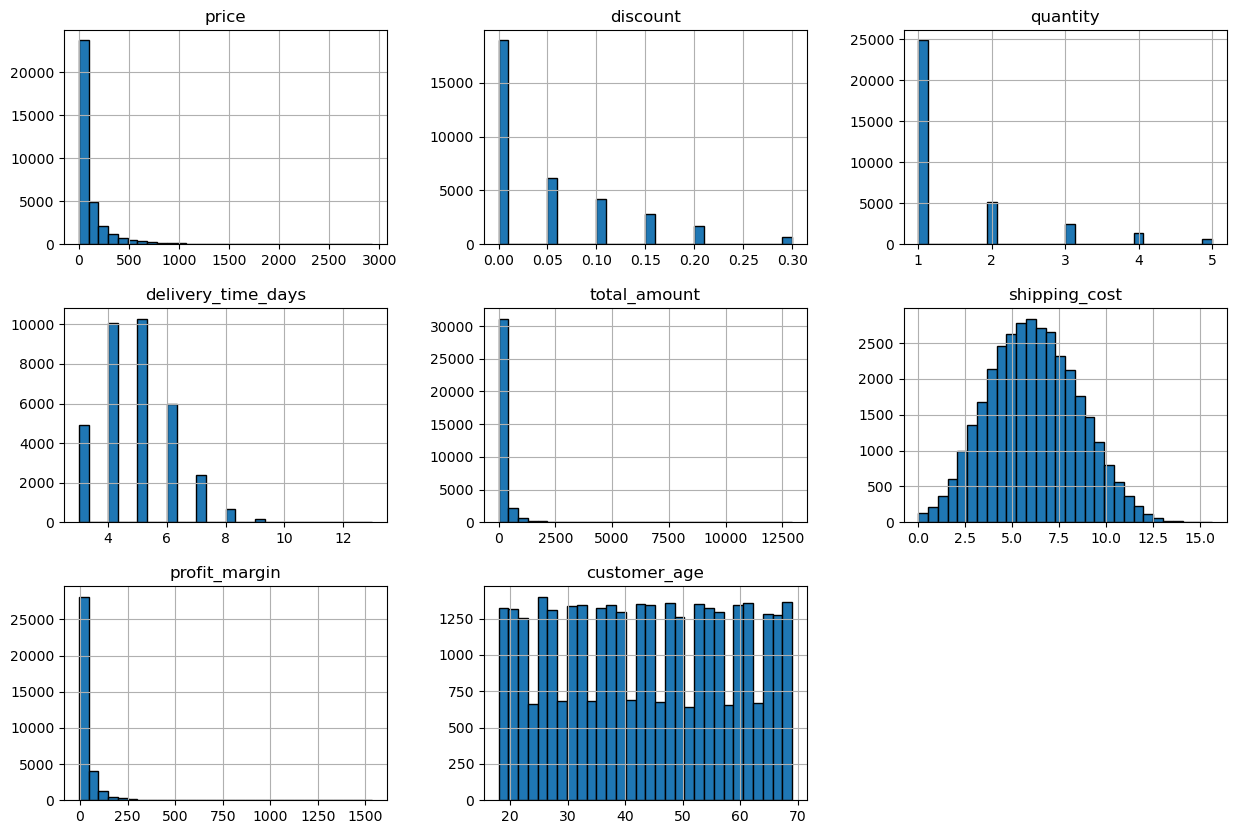

In [11]:
df[numeric_cols].hist(bins=30, edgecolor='black', figsize=(15,10))
dpi = 400

Findings:

- Price, total amount, and profit margin show right skew.

- Typical in e‑commerce: most orders are low‑value, with a long tail of high‑ticket items.

Business context:

- Highlights the need for normalization/log‑scaling in ML models.

- Confirms dashboards reflect realistic spending distributions.

#### Outlier Detection

We apply the IQR rule to flag statistical outliers.

In [12]:
outlier_counts = {}
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < (Q1 - 1.5*IQR)) | (df[col] > (Q3 + 1.5*IQR))]
    outlier_counts[col] = outliers.shape[0]

pd.Series(outlier_counts, name='Potential Outliers')

price                 3632
discount               704
quantity              2070
delivery_time_days      27
total_amount          3792
shipping_cost           48
profit_margin         3025
customer_age             0
Name: Potential Outliers, dtype: int64

Findings:

- Thousands of flagged values across price, total amount, profit margin, etc.

- For the business context, it is safe to assume that these are not errors as outliers may reflect bulk purchases, luxury items, promotions, and returns.

- No filtering applied to preserve business realism.

Business context:

- Outliers may enrich dashboards by showing diverse customer behaviors.

- Removing them would distort Actual Return Rate by Category and spending patterns.

#### Cardinality Profile

In [13]:
categorical_cols = df.select_dtypes(include='object').columns
df[categorical_cols].nunique() 

order_id           34500
customer_id         7903
product_id         24912
category               7
payment_method         6
region                 5
returned               2
customer_gender        3
dtype: int64

Findings:

- ~7,900 unique customers, ~24,900 products.

- 7 categories, 6 payment methods, 5 regions.

- Binary return flag, 3 gender values.

Business context:

- Appropriate mix for segmentation, cohort analysis, and feature engineering.

- Supports dashboards like Sales by Category and Delivery Speed Breakdown.



### Feature Engineering 

In [14]:
# --- 1. Copy original df ---
df_fe = df.copy()

#### Basic Features

We enrich the dataset with features that capture customer behavior, product history, and operational dynamics. These engineered fields bridge raw transactions with both Tableau dashboards and predictive modeling.

In [15]:
df_fe['delivery_speed'] = df_fe['delivery_time_days']
df_fe['discount_bucket'] = pd.cut(
    df_fe['discount'], bins=[-0.01, 0.01, 0.10, 0.30],
    labels=['No Discount', 'Low Discount', 'High Discount']
)
df_fe['total_cost_ratio'] = df_fe['shipping_cost'] / (df_fe['total_amount'] + 1)
df_fe['order_value_segment'] = pd.cut(
    df_fe['total_amount'],
    bins=[0, 50, 200, 500, df_fe['total_amount'].max()],
    labels=['Low Value', 'Mid Value', 'High Value', 'Very High']
)
df_fe['returned_flag'] = df_fe['returned'].map({'Yes': 1, 'No': 0})


Delivery speed buckets → Tableau chart: Delivery Speed Breakdown.

Discount buckets & order value segments → Tableau chart: Sales by Category.

Returned flag → foundation for Actual Return Rate by Category.

#### Customer & Product Histories

In [16]:
df_fe = df_fe.sort_values(by='order_date')
df_fe['past_orders'] = df_fe.groupby('customer_id').cumcount()
df_fe['past_returns'] = df_fe.groupby('customer_id')['returned_flag'].cumsum().shift(fill_value=0)
df_fe['product_orders_cum'] = df_fe.groupby('product_id').cumcount()
df_fe['product_returns_cum'] = df_fe.groupby('product_id')['returned_flag'].cumsum().shift(fill_value=0)
df_fe['product_return_rate'] = (
    df_fe['product_returns_cum'] / df_fe['product_orders_cum'].replace(0, np.nan)
).fillna(0)

- Tracks customer loyalty and return behavior.

- Tracks product reliability via cumulative return rates.

- Inputs for predictive modeling and Tableau chart: Top Drivers of Product Returns.

#### Recency Features

In [17]:
df_fe['days_since_last_order'] = (
    df_fe.groupby('customer_id')['order_date'].diff().dt.days.fillna(9999)
)
df_fe['return_date_only'] = df_fe['order_date'].where(df_fe['returned_flag'] == 1)
df_fe['last_return_date'] = (
    df_fe.groupby('customer_id')['return_date_only'].shift().groupby(df_fe['customer_id']).ffill()
)
df_fe['days_since_last_return'] = (
    (df_fe['order_date'] - df_fe['last_return_date']).dt.days.fillna(9999)
)
df_fe.drop(columns=['return_date_only'], inplace=True)


- Measures customer activity gaps and return recency.

- Critical for churn analysis and predictive modeling.

#### Rolling features

In [18]:
df_fe['returns_last3'] = (
    df_fe.groupby('customer_id')['returned_flag']
    .rolling(3, min_periods=1).sum().shift().reset_index(level=0, drop=True).fillna(0)
)

- Captures short-term return streaks.

- Business context: customers with frequent recent returns may be high-risk.

#### Category-Level Return Rates

In [19]:
category_return_rate = df_fe.groupby('category')['returned_flag'].mean()
df_fe['category_return_rate'] = df_fe['category'].map(category_return_rate)

- Provides baseline return risk per category.

- Tableau chart: Actual Return Rate by Category.



#### Interaction & Temporal Features

In [20]:
df_fe['delivery_speed_bucket'] = pd.cut(
    df_fe['delivery_speed'], bins=[0, 3, 5, 7, 14],
    labels=['Fast', 'Normal', 'Slow', 'Very Slow']
)
df_fe['discount_category'] = df_fe['discount_bucket'].astype(str) + "_" + df_fe['category']
df_fe['price_per_unit'] = df_fe['price'] / df_fe['quantity']
df_fe['customer_tenure_days'] = (
    df_fe['order_date'] - df_fe.groupby('customer_id')['order_date'].transform('min')
).dt.days
df_fe['order_month'] = df_fe['order_date'].dt.month
df_fe['order_weekday'] = df_fe['order_date'].dt.weekday


- Delivery speed buckets is for tableau chart: Delivery Speed Breakdown.

- Discount and category interactions is for predictive modeling.

- Customer tenure, month, weekday is for  seasonality and cohort dashboards.

Outcome:

- Dataset expanded from 17 to 38 columns.

- Engineered features directly support Tableau dashboards and predictive modeling.

- This step bridges raw transactions with business insights and ML signals.

###  ML Pipeline: Predicting Returns from Order Features

In [21]:
from catboost import CatBoostClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import numpy as np
import matplotlib.pyplot as plt


#### Feature Selection

We define numeric and categorical features engineered earlier.

In [22]:
numeric_features = [
    'delivery_speed','total_cost_ratio','past_orders','past_returns',
    'product_return_rate','customer_age','days_since_last_order',
    'days_since_last_return','price_per_unit','customer_tenure_days',
    'returns_last3','category_return_rate'
]
categorical_features = [
    'discount_bucket','order_value_segment','payment_method','region',
    'customer_gender','discount_category','delivery_speed_bucket','category'
]

X = df_fe[numeric_features + categorical_features]
y = df_fe['returned_flag']


Business context:

- Numeric features capture operational and behavioral signals.

- Categorical features capture segmentation (payment, region, discount, category).

- Together, they form the basis for predicting product returns.

#### Data Preparation

Convert categorical fields to string dtype for CatBoost compatibility.

In [23]:
for col in categorical_features:
    X[col] = X[col].astype(str)

/var/folders/59/79bsx4qn3pvg02rp6sgg9mp40000gn/T/ipykernel_20789/3775147872.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype(str)
/var/folders/59/79bsx4qn3pvg02rp6sgg9mp40000gn/T/ipykernel_20789/3775147872.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype(str)
/var/folders/59/79bsx4qn3pvg02rp6sgg9mp40000gn/T/ipykernel_20789/3775147872.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

(Note: In production, use .loc to avoid SettingWithCopyWarning. Here, conversion is safe and results are correct.)

####  Train/Test Split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

- Stratified split preserves class balance.

- 20% of data reserved for testing.

#### Catboost Classifier

In [25]:
clf_cb = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.02,
    depth=7,
    l2_leaf_reg=7,
    random_seed=42,
    cat_features=categorical_features,
    verbose=0,
    auto_class_weights='Balanced'
)

clf_cb.fit(X_train, y_train)
y_proba_cb = clf_cb.predict_proba(X_test)[:, 1]

#### Threshold Tuning

In [26]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_cb)
f1_scores = (2 * precision * recall) / (precision + recall + 1e-9)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[max(best_idx - 1, 0)]
y_pred_cb = (y_proba_cb >= best_threshold).astype(int)

- Threshold tuned for best F1 score.

- Improves recall for minority class (returns).

#### Model Evaluation

In [27]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_cb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_cb))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_proba_cb))

Confusion Matrix:
 [[5235 1284]
 [ 263  118]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.80      0.87      6519
           1       0.08      0.31      0.13       381

    accuracy                           0.78      6900
   macro avg       0.52      0.56      0.50      6900
weighted avg       0.90      0.78      0.83      6900


ROC-AUC Score: 0.589575233146478


#### Precision-Recall Curve

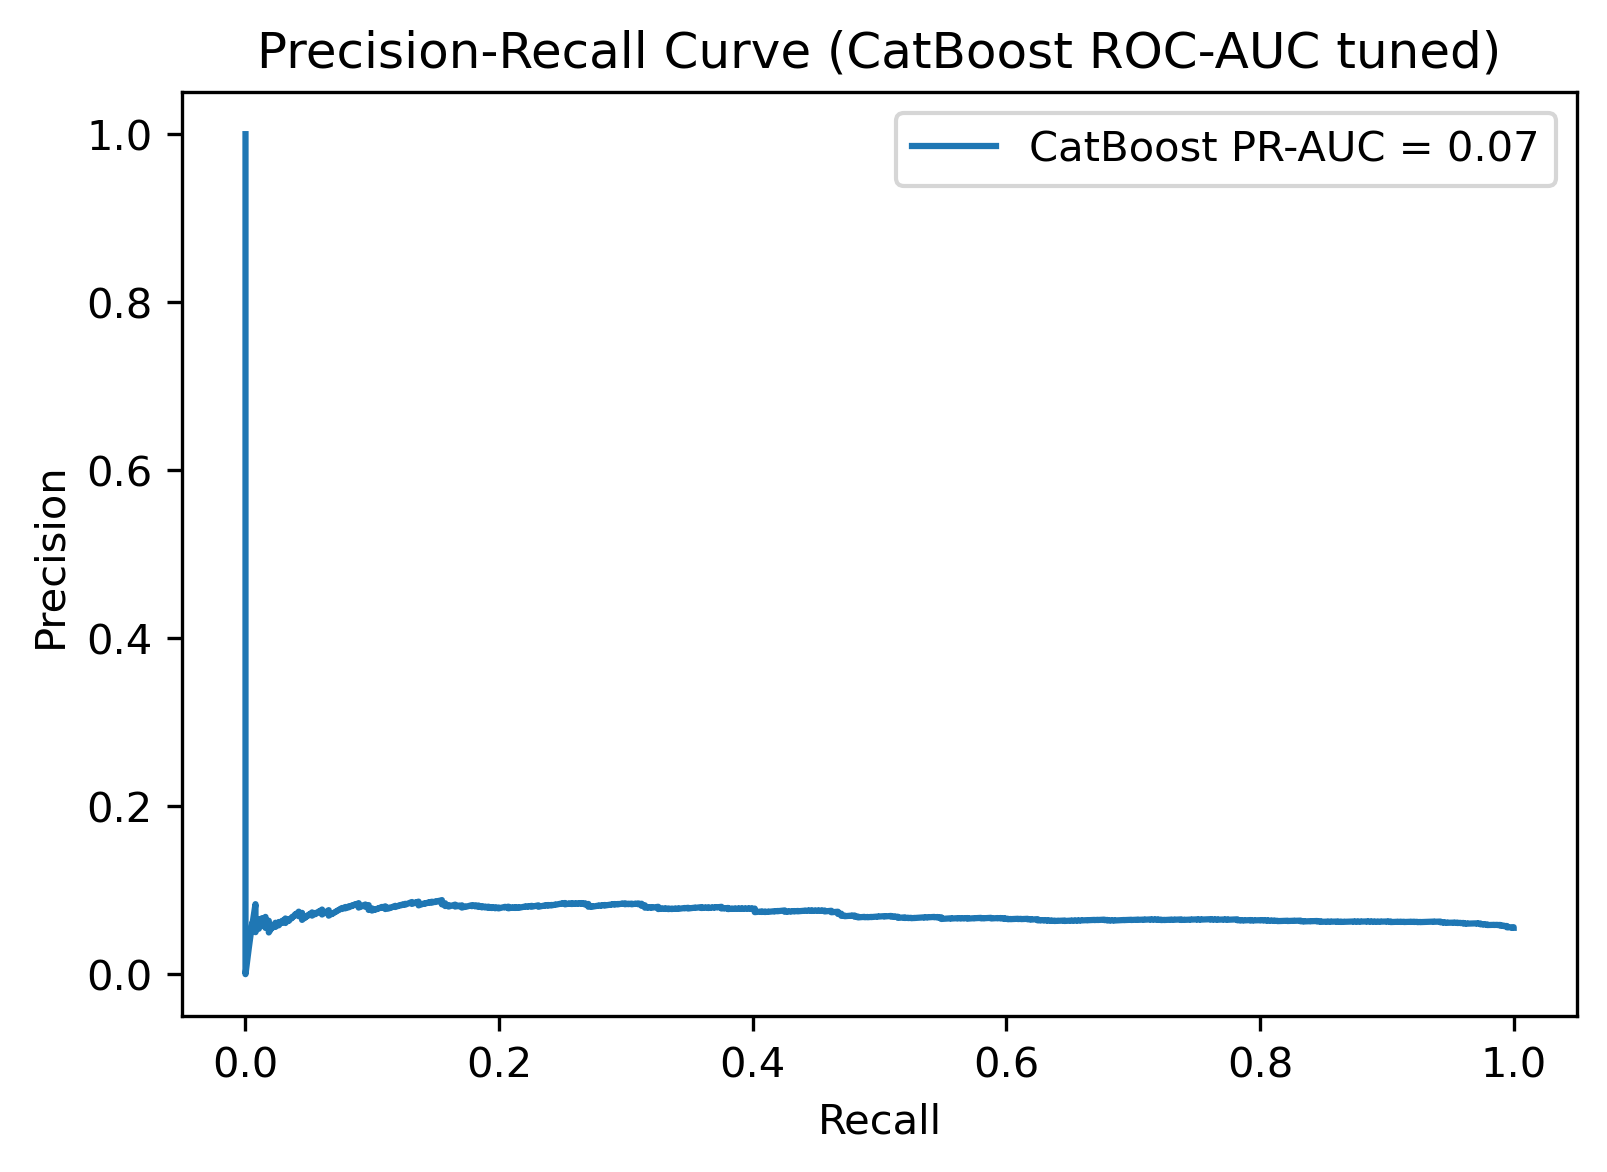

In [28]:
plt.figure(figsize=(6,4), dpi=300 )
plt.plot(recall, precision, label=f'CatBoost PR-AUC = {auc(recall, precision):.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (CatBoost ROC-AUC tuned)')
plt.legend()
plt.show()

Visualizes trade‑off between precision and recall.

#### Export Unified Dataset (with Feature Importance)


Top 15 Features Driving Return Predictions:
                  Feature  Importance
8          price_per_unit   12.633393
1        total_cost_ratio   10.033463
5            customer_age    9.767417
6   days_since_last_order    9.726665
9    customer_tenure_days    8.875772
11   category_return_rate    6.282123
17      discount_category    5.962557
14         payment_method    5.749962
15                 region    4.592989
2             past_orders    3.977483
19               category    3.690242
18  delivery_speed_bucket    3.489476
0          delivery_speed    3.264956
12        discount_bucket    2.893141
13    order_value_segment    2.666445


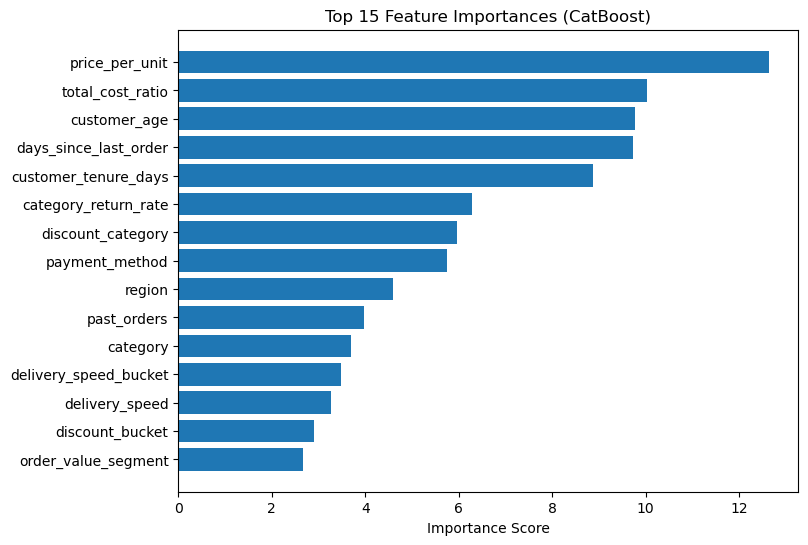

Unified processed dataset with predictions saved to: /Users/neilkeannedelavega/Downloads/E-commerce-Data-Insights-Dashboard/ecommerce_processed_with_predictions.csv


In [29]:
# --- 7. Feature importance (fixed Pool call) ---
feature_importances = clf_cb.get_feature_importance(
    Pool(X_train, y_train, cat_features=categorical_features)
)
feature_names = numeric_features + categorical_features

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nTop 15 Features Driving Return Predictions:")
print(importance_df.head(15))

# --- 8. Plot feature importance ---
plt.figure(figsize=(8,6))
plt.barh(importance_df['Feature'][:15][::-1], importance_df['Importance'][:15][::-1])
plt.xlabel("Importance Score")
plt.title("Top 15 Feature Importances (CatBoost)")
plt.show()

# --- 9. Attach feature importance scores as columns ---
importance_dict = dict(zip(importance_df['Feature'], importance_df['Importance']))
for feature, score in importance_dict.items():
    df_fe[f'FI_{feature}'] = score

# --- 10. Define output directory ---
output_dir = r"/Users/neilkeannedelavega/Downloads/E-commerce-Data-Insights-Dashboard"
os.makedirs(output_dir, exist_ok=True)

# --- 11. Attach predictive results ---
df_fe['predicted_proba'] = clf_cb.predict_proba(X)[:, 1]
df_fe['predicted_flag'] = clf_cb.predict(X)

# --- 12. Add model metadata ---
roc_auc_val = roc_auc_score(y_test, y_proba_cb)
df_fe['model_best_threshold'] = best_threshold
df_fe['model_roc_auc'] = roc_auc_val

# --- 13. Save final unified CSV ---
final_path = os.path.join(output_dir, "ecommerce_processed_with_predictions.csv")
df_fe.to_csv(final_path, index=False)

print(f"Unified processed dataset with predictions saved to: {final_path}")


Top Drivers of Returns:

- price_per_unit, total_cost_ratio, customer_age, days_since_last_order, customer_tenure_days

- Tableau chart: Top Drivers of Product Returns is derived directly from this ranking.

- Predictions and metadata attached to dataset.

- Unified CSV exported for Tableau integration.

#### Reload & Verify

In [30]:
df_processed = pd.read_csv(final_path)
df_processed.head()

,order_id,customer_id,product_id,category,price,discount,quantity,payment_method,order_date,delivery_time_days,...,FI_order_value_segment,FI_days_since_last_return,FI_past_returns,FI_customer_gender,FI_returns_last3,FI_product_return_rate,predicted_proba,predicted_flag,model_best_threshold,model_roc_auc
0,O104424,C17986,P210334,Grocery,15.51,0.0,1,COD,2023-09-12,6,...,2.666445,1.876437,1.713193,1.357279,0.897992,0.549014,0.131875,0,0.540661,0.589575
1,O111514,C14753,P227222,Fashion,99.01,0.0,1,Debit Card,2023-09-12,4,...,2.666445,1.876437,1.713193,1.357279,0.897992,0.549014,0.492578,0,0.540661,0.589575
2,O121362,C16175,P221392,Fashion,30.99,0.0,2,Credit Card,2023-09-12,6,...,2.666445,1.876437,1.713193,1.357279,0.897992,0.549014,0.545178,1,0.540661,0.589575
3,O126442,C11841,P248993,Fashion,31.75,0.0,1,UPI,2023-09-12,5,...,2.666445,1.876437,1.713193,1.357279,0.897992,0.549014,0.598147,1,0.540661,0.589575
4,O134456,C17939,P217561,Toys,36.68,0.0,1,UPI,2023-09-12,5,...,2.666445,1.876437,1.713193,1.357279,0.897992,0.549014,0.452207,0,0.540661,0.589575
